# Lesson 4.01 - Logistic Regression
Logistic Regression is a Machine Learning method you can use to predict the value of a numeric categorical variable based on its relationship with predictor variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [3]:
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Logistic regression on the titanic dataset

In [4]:
address = 'data/titanic-training-data.csv'
titanic_training = pd.read_csv(address)
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
print(titanic_training.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
# Check the number of non-null values recorded for each column
print(titanic_training.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Checking that your target variable is binary

<AxesSubplot:xlabel='Survived', ylabel='count'>

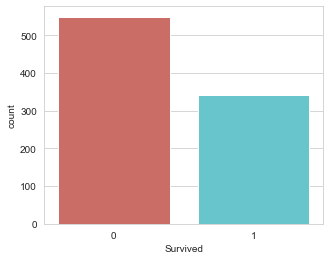

In [6]:
# There are only 2 classes of values for target variable as seen below in the chart
sb.countplot(x='Survived', data=titanic_training, palette='hls')

### Checking for missing values

In [7]:
# 3 columns have missing values that we need to deal with before we apply the model
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [8]:
# after dropping irrelevant columns, store as new data frame since the dropped columns 
# may be considered if model performance is not satisfactory
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values

<AxesSubplot:xlabel='Parch', ylabel='Age'>

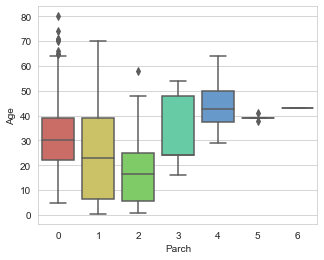

In [9]:
# impute missing values for age based on the Parch frequency
# Based on chart below, we can see that different Parch values have diff age ranges
sb.boxplot(x='Parch', y='Age', data=titanic_data, palette='hls')

In [10]:
# Based on table below, we can see that different Parch values have diff mean ages
# We will use the mean age for each Parch value for our mssing value imputation
Parch_groups = titanic_data.groupby(titanic_data['Parch'])
Parch_groups.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


In [11]:
def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
        
    else:
        return Age

In [12]:
titanic_data['Age']= titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [13]:
titanic_data.dropna(inplace=True)
titanic_data.reset_index(inplace=True, drop=True)

print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


### Converting categorical variables to a dummy indicators

In [14]:
import pandas as pd

# Drop gender and embarked columns if they have been determined to be irrelevant 
# since their new created dummies will be used instead

# 'Columns' parameter specifies where to do the One Hot Encoding.
titanic_dmy = pd.get_dummies(data=titanic_data, columns=['Sex', 'Embarked'])

In [15]:
titanic_dmy.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,1


### Checking for independence between features

<AxesSubplot:>

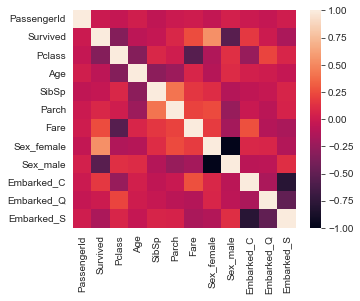

In [16]:
sb.heatmap(titanic_dmy.corr())

In [17]:
# Drop the predictors (X-variables) that share high correlation scores
titanic_dmy.drop(['Fare','Pclass', 'Sex_female'], axis=1, inplace=True)
titanic_dmy.head()

,PassengerId,Survived,Age,SibSp,Parch,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,1,0,0,1
1,2,1,38.0,1,0,0,1,0,0
2,3,1,26.0,0,0,0,0,0,1
3,4,1,35.0,1,0,0,0,0,1
4,5,0,35.0,0,0,1,0,0,1


### Checking that your dataset size is sufficient (e.g. at least 500 rows)

In [18]:
titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Age          889 non-null    float64
 3   SibSp        889 non-null    int64  
 4   Parch        889 non-null    int64  
 5   Sex_male     889 non-null    uint8  
 6   Embarked_C   889 non-null    uint8  
 7   Embarked_Q   889 non-null    uint8  
 8   Embarked_S   889 non-null    uint8  
dtypes: float64(1), int64(4), uint8(4)
memory usage: 38.3 KB


In [19]:
X_train, X_test, y_train, y_test = train_test_split(titanic_dmy.drop('Survived', axis=1),
                                                   titanic_dmy['Survived'], test_size=0.25,
                                                   random_state=150)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(666, 8)
(666,)
(223, 8)
(223,)


In [21]:
X_train[0:5]

,PassengerId,Age,SibSp,Parch,Sex_male,Embarked_C,Embarked_Q,Embarked_S
342,344,25.0,0,0,1,0,0,1
106,108,32.0,0,0,1,0,0,1
92,94,26.0,1,2,1,0,0,1
546,548,32.0,0,0,1,1,0,0
124,126,12.0,1,0,1,1,0,0


### Deploying and evaluating the model

In [22]:
# Scikit-learn ships with five different solvers. 
# Each solver tries to find the parameter weights that minimize a cost function.
# More info can be found at https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [23]:
y_pred = LogReg.predict(X_test)

In [24]:
y_pred[170]

1

## Model Evaluation
### Classification report without cross-validation

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       139
           1       0.77      0.71      0.74        84

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



### K-fold cross-validation & confusion matrices

In [26]:
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[359,  51],
       [ 90, 166]], dtype=int64)

In [27]:
precision_score(y_train, y_train_pred)

0.7649769585253456

### Make a test prediction - Optional

In [28]:
# Check the actual target value of the sample row
# 532 refers to the passenger ID
# 1 refers to the actual Survived status

print(y_test[170:171])

532    1
Name: Survived, dtype: int64


In [29]:
# Store the predictors for the sample row
test_passenger = X_test[170:171]

In [30]:
print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

# LogReg predicts Class = 1 i.e. passenger survives
# LogReg determines the predicted class based on the predicted prob for each class
# The class that has the highest predicted prob is determined to be the predicted class

[1]
[[0.11769757 0.88230243]]
